# NYC MTA & Weather Data Analysis
___

With a cleaned MTA & weather dataset - let's bring them together to see what pleasant busy days look like in NYC.

In [20]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
from dateutil.parser import parse
from matplotlib import dates
from datetime import datetime

sns.set_style('white')


## 1. Import our nyc_mta dataset

In [2]:
# import our nyc_mta data
nyc_mta = pd.read_csv('./data/nyc_mta_pleasant_days.csv', parse_dates=['date'])

In [3]:
nyc_mta.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 42880 entries, 0 to 42879
Data columns (total 6 columns):
date            42880 non-null datetime64[ns]
station         42880 non-null object
line            42880 non-null object
division        42880 non-null object
ridership       42880 non-null int64
pleasant_day    42880 non-null bool
dtypes: bool(1), datetime64[ns](1), int64(1), object(3)
memory usage: 1.7+ MB


We want to have a summarized ridership per day - let's group the dataframe to achieve this

In [5]:
# summarize by ridership
nyc_mta_ridership = nyc_mta.groupby('date').ridership.sum()
nyc_mta_ridership = nyc_mta_ridership.to_frame('ridership')

# summarize by pleasant day
nyc_mta_pleasant_days = nyc_mta.groupby('date').pleasant_day.first()

## 2. Import our pleasant day nyc_weather data

In [6]:
# import our weather data
nyc_weather = pd.read_csv('./data/nyc_weather_pleasant_days.csv', index_col=[0,1])

In [7]:
nyc_weather.info()

<class 'pandas.core.frame.DataFrame'>
MultiIndex: 92 entries, (8, 1) to (10, 31)
Data columns (total 6 columns):
temp_max         92 non-null float64
temp_min         92 non-null float64
temp_avg         92 non-null float64
precipitation    92 non-null float64
month_day        92 non-null object
pleasant_day     92 non-null bool
dtypes: bool(1), float64(4), object(1)
memory usage: 4.2+ KB


In [8]:
nyc_weather.head()

temp_max   temp_min   temp_avg  precipitation month_day  \
month day                                                             
8     1    84.333333  71.666667  78.000000       0.000000    Aug 01   
      2    80.666667  67.333333  74.000000       0.136667    Aug 02   
      3    82.000000  69.000000  75.500000       0.023333    Aug 03   
      4    84.666667  68.666667  76.666667       0.143333    Aug 04   
      5    86.666667  70.666667  78.666667       0.000000    Aug 05   

          pleasant_day  
month day               
8     1           True  
      2          False  
      3           True  
      4          False  
      5           True

We currently have the month/date within the nyc_weather dataframe.  Let's convert that to an actual datetime value

In [9]:
# let's convert the date into an acutal datetime 
nyc_weather['date'] = [parse(date + ' 2016') for date in nyc_weather['month_day']]
nyc_weather.set_index('date', inplace=True)
nyc_weather.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 92 entries, 2016-08-01 to 2016-10-31
Data columns (total 6 columns):
temp_max         92 non-null float64
temp_min         92 non-null float64
temp_avg         92 non-null float64
precipitation    92 non-null float64
month_day        92 non-null object
pleasant_day     92 non-null bool
dtypes: bool(1), float64(4), object(1)
memory usage: 4.4+ KB


In [10]:
nyc_weather.head()

,temp_max,temp_min,temp_avg,precipitation,month_day,pleasant_day
date,,,,,,
2016-08-01,84.333333,71.666667,78.000000,0.000000,Aug 01,True
2016-08-02,80.666667,67.333333,74.000000,0.136667,Aug 02,False
2016-08-03,82.000000,69.000000,75.500000,0.023333,Aug 03,True
2016-08-04,84.666667,68.666667,76.666667,0.143333,Aug 04,False
2016-08-05,86.666667,70.666667,78.666667,0.000000,Aug 05,True


In [11]:
# Summarize by pleasant days
nyc_weather_pleasant_days = nyc_weather[nyc_weather.pleasant_day == True]

## 3. Explore MTA vs Weather datasets

In [12]:
# merge the datasets together
nyc_mta_weather = pd.merge(nyc_weather, nyc_mta_ridership, left_index=True, right_index=True, how='left')

# select only the columns we need
nyc_mta_weather = nyc_mta_weather[['temp_avg', 'precipitation', 'ridership', 'month_day']]

In [13]:
nyc_mta_weather.head()

,temp_avg,precipitation,ridership,month_day
date,,,,
2016-08-01,78.000000,0.000000,5172413.0,Aug 01
2016-08-02,74.000000,0.136667,5542629.0,Aug 02
2016-08-03,75.500000,0.023333,5687754.0,Aug 03
2016-08-04,76.666667,0.143333,5673306.0,Aug 04
2016-08-05,78.666667,0.000000,5456328.0,Aug 05


In [14]:
# let's build a correlation to see if we have any data related
nyc_mta_weather.dropna(axis=0, how='any', inplace=True)

# drop the 'month_day' column as we don't need it
c=nyc_mta_weather[['temp_avg', 'precipitation', 'ridership']]

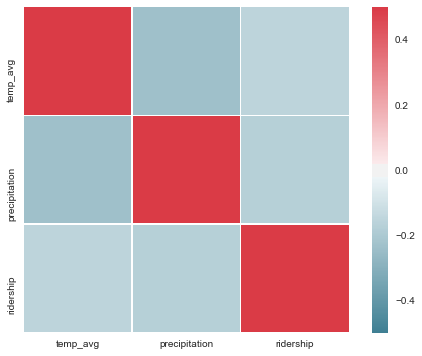

In [15]:
# builder the correlation
corr = c.corr()

# Set up the matplotlib figure
fig, ax = plt.subplots(figsize=(8, 6))

# Generate a custom diverging colormap
cmap = sns.diverging_palette(220, 10, as_cmap=True)

# Draw the heatmap
sns.heatmap(corr, cmap=cmap, vmax=.5, center=0,
            square=True, linewidths=.5)

fig.savefig('./figures/nyc_weather_corr')
plt.show()

Based on the correlation, we can see that 
* Ridership is slightly negatively correlated to temperature (meaning as temperature decreases, ridership increases)
* Ridership is also slightly negatively correlated to precipitation (meaning as precipitation descreases, ridership increases - we shouldn't read into this too deeply - I believe the large number of days with no precipitation impacts this correlation.  We also see that precipitation can happen on warm days as well - which drives down ridership.)

To recap - we've identified pleasant days as being
* Tuesday, Wednesday, Thrusday, Friday
* Average temperature >= 60F
* Precipitation < 0.5 mm

Combining all of this data together - we can see a graph below summarizing pleasant days and the ridership associated to those days.  In total, we have 29 days of pleasant weather.  

In [16]:
# find the pleasant days in our MTA dataset
mta_pleasant_days_list = list(nyc_mta_pleasant_days[nyc_mta_pleasant_days == True].index)

# find the pleasant days in our weather dataset that overlap with the mta pleasant days
mta_weather_pleasant_days = nyc_weather_pleasant_days[nyc_weather_pleasant_days.index.isin(mta_pleasant_days_list)]

# find the unpleasant days in our weather dataset
mta_weather_unpleasant_days = nyc_mta_weather[~nyc_mta_weather.index.isin(list(mta_weather_pleasant_days.index))]

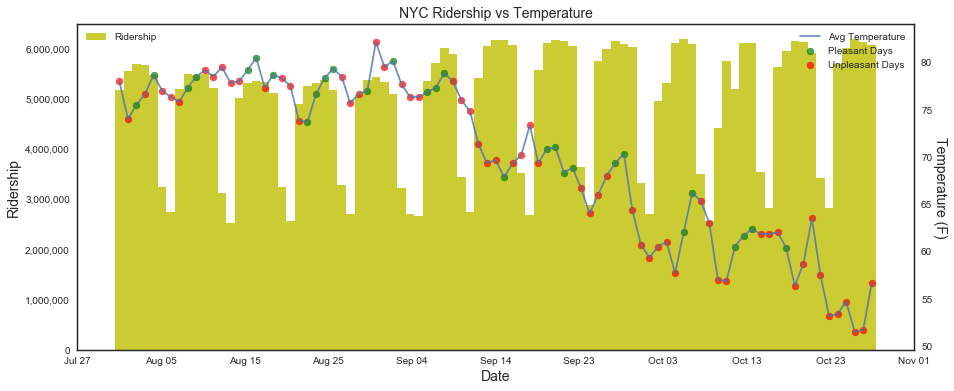

In [26]:
# setup the plot
fig, ax = plt.subplots(figsize=(15,6)) 

# find the plot for ridership
x_r = dates.date2num([datetime.strptime(d, '%b %d') for d in nyc_mta_weather.month_day])
y_r = nyc_mta_weather.ridership

# find the pleasant days
x_p = dates.date2num([datetime.strptime(d, '%b %d') for d in mta_weather_pleasant_days.month_day])
y_p = mta_weather_pleasant_days.temp_avg

# find the unpleasant days
x_up = dates.date2num([datetime.strptime(d, '%b %d') for d in mta_weather_unpleasant_days.month_day])
y_up = mta_weather_unpleasant_days.temp_avg

# find the temp data
x_t = dates.date2num([datetime.strptime(d, '%b %d') for d in nyc_mta_weather.month_day])
y_t = nyc_mta_weather.temp_avg

# plot ridership
ax.bar(x_r, y_r, alpha=0.8, label='Ridership', width=1, color='y')

# create 2nd axis and plot avg temperature
ax2 = ax.twinx()
ax2.plot(x_t, y_t, alpha=0.8, label='Avg Temperature')
ax2.grid(False)

# add our pleasant/unpleasant days to the 2nd axis
ax2.scatter(x_p, y_p, alpha=0.7, label='Pleasant Days', color='g')
ax2.scatter(x_up, y_up, alpha=0.7, label='Unpleasant Days', color='r')

# setup our xaxis labels
date_formatter = dates.DateFormatter('%b %d')
ax.xaxis.set_major_formatter(date_formatter)
ax.xaxis.set_major_locator(ticker.LinearLocator())

# set the y axis ticks
start, end = ax.get_ylim()
ax.yaxis.set_major_formatter(ticker.FuncFormatter(lambda x, p: format(int(x), ',')))

# set the labels
plt.title('NYC Ridership vs Temperature', fontsize=14)
ax.set_ylabel('Ridership', fontsize=14)
ax.set_xlabel('Date', fontsize=14)
ax2.set_ylabel('Temperature (F)', rotation=270, labelpad=15, fontsize=14)

ax.legend(loc=2)
ax2.legend(loc=1)

fig.savefig('./figures/nyc_weather_mta_pleasant_days')
plt.show()

## 4. Conclusions

Knowing this, how can we apply this to predicting days for 2017?

* For busy days - we know that we want to keep only Tuesdays, Wednesdays, Thursdays, Fridays.  
* For pleasant days - we can compare to our list of historically pleasant days.

This should give us our list of pleasant busy days in 2017

In [23]:
# create days in 2017 Aug - October
datelist = pd.date_range('2017-8-1', periods=92)

# filter out Saturday, Sunday, Monday
days = [d for d in datelist if d.dayofweek in [1,2,3,4]]

# find the historically pleasant days
historically_pleasant_days = list(nyc_weather_pleasant_days.index)

# compare 2017 days to see if they were pleasant in our historically pleasant days
pleasant_days_2017 = [d for d in days if d.replace(year=2016) in historically_pleasant_days]


**How many pleasant days do we have in 2017?**

In [24]:
len(pleasant_days_2017)

30

**What days should be pleasant and busy in 2017?**

In [25]:
for d in pleasant_days_2017:
    print(d.strftime('%a %b %d %Y'))

Tue Aug 01 2017
Thu Aug 03 2017
Tue Aug 08 2017
Wed Aug 09 2017
Thu Aug 10 2017
Tue Aug 15 2017
Wed Aug 16 2017
Thu Aug 17 2017
Tue Aug 22 2017
Wed Aug 23 2017
Thu Aug 24 2017
Fri Aug 25 2017
Tue Aug 29 2017
Wed Aug 30 2017
Tue Sep 05 2017
Wed Sep 06 2017
Thu Sep 07 2017
Fri Sep 08 2017
Fri Sep 15 2017
Wed Sep 20 2017
Thu Sep 21 2017
Fri Sep 22 2017
Tue Sep 26 2017
Thu Sep 28 2017
Fri Sep 29 2017
Fri Oct 06 2017
Thu Oct 12 2017
Fri Oct 13 2017
Tue Oct 17 2017
Wed Oct 18 2017
